In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re
from glob import glob
import subprocess as sbp

In [18]:
omd_files = glob(os.path.join('..', '*.omd'))
deviations = 0
for _omd in omd_files:
    with open(_omd, mode='r', encoding='utf8') as r_file:
        for line in r_file:
            if line.startswith('   NOTICE NN Worker : Deviation'):
                deviations += 1
print(f'deviations over 4.184 kj/mol: {deviations} ~ {(deviations/100000)*100:.3f} %')

deviations over 4.184 kj/mol: 4 ~ 0.004 %


In [17]:
#os.system('chmod u+x ./ana.sh')
#sbp.run(['./ana.sh'])

In [19]:
# GEOMETRY
rmsd_raw = os.path.join('.', 'rmsd', 'rmsd_meoh.out')
rdf_raw = os.path.join('.', 'rdf', 'rdf_ob_ow.out')
energies = [os.path.join('.', 'ene_ana', 'totene.dat'), 
            os.path.join('.', 'ene_ana', 'totpot.dat'), 
            os.path.join('.', 'ene_ana', 'totkin.dat'),
            os.path.join('.', 'ene_ana', 'nnvalid.dat'), 
            os.path.join('.', 'ene_ana', 'totqm.dat')]
tser_raw = os.path.join('.', 'tser', 'tser_meoh.out')
hbond_raw = glob(os.path.join('.', 'hbond', '*.out'))

In [20]:
def basic_func(file: str) -> list:
    with open(file, mode='r', encoding='utf8') as r_file:
        prop = []
        for line in r_file.readlines():
            if not line.startswith('#') and line != '\n':
                prop.append([float(x) for x in re.sub(r'\s+', ' ', line).strip().split(' ')])
        return prop

def rmsd(rmsd_output: str):
    _rmsd = basic_func(rmsd_output)
    rmsd_data = pd.DataFrame(_rmsd, columns=['Time [ps]', 'RMSD [nm]'])
    rmsd_data.set_index('Time [ps]', inplace=True)
    return rmsd_data

def rdf(rdf_output: str):
    _rdf = basic_func(rdf_output)
    rdf_data = pd.DataFrame(_rdf, columns=['r [nm]', 'rdf'])
    rdf_data.set_index('r [nm]', inplace=True)
    return rdf_data

def energy(energy_files: list):
    energy_data = pd.DataFrame()
    for file in energy_files:
        col = file.split('/')[-1].split('.')[0]
        _ene = basic_func(file)
        if 'Time [ps]' in energy_data.index:
            energy_data[col] = [x[1] for x in _ene]
        else:
            energy_data['Time [ps]'] = [x[0] for x in _ene]
            energy_data[col] = [x[1] for x in _ene]
    energy_data.set_index('Time [ps]', inplace=True)
    return energy_data

def tser(tser_output: str, df_columns: list):
    _tser = basic_func(tser_output)
    tser_data = pd.DataFrame(_tser, columns=df_columns)
    tser_data.set_index(df_columns[0], inplace=True)
    return tser_data

def parse_hbond_out(file: str) -> list:
    with open(file, mode='r', encoding='utf8') as r_file:
        prop = []
        for line in r_file.readlines():
            if not line.startswith('#') and line != '\n':
                line = re.sub(r'\s+', ' ', line).strip().split(' ')
                _list = []
                for item in line:
                    try:
                        _list.append(float(item))
                    except ValueError:
                        _list.append(item)
                prop.append(_list)
        return prop

def hbond(hbond_output: list):
    hbond_output = sorted(hbond_output)
    n_o_hbonds = basic_func(hbond_output[1])
    n_o_hbond_data = pd.DataFrame(n_o_hbonds, columns=['Time [ps]', 'Num of hbonds'])
    
    i_o_hbonds = basic_func(hbond_output[0])
    i_o_hbond_data = pd.DataFrame(i_o_hbonds, columns=['Time [ps]', 'Index of hbond'])
    #i_o_hbond_data.set_index('Time [ps]', inplace=True)

    _hbond = parse_hbond_out(hbond_output[2])
    hbond_data = pd.DataFrame(_hbond, columns=['ID', 'Mol', 'Res', 'DONOR', '-', 'Mol', 'Res', 'ACC', 'Atom', 'D', '-', 'Atom', 'H', '...', 'Atom', 'A', 'DIST', 'ANGLE', 'OCCUR', '%'])
    #n_o_hbond_data.merge(i_o_hbond_data, how='left')
    hbond_data.drop('-', axis=1, inplace=True)
    hbond_data.drop('...', axis=1, inplace=True)
    return n_o_hbond_data, i_o_hbond_data, hbond_data

In [21]:
n_hbond_data, i_hbond_data, hbond_data = hbond(hbond_raw)
#i_hbond_data.plot.scatter(x='Time [ps]', y='Index of hbond', marker='s')
#n_hbond_data.plot.hist(y='Num of hbonds', bins=4, linewidth=0.5)

In [22]:
donor_meoh_data = hbond_data[hbond_data['DONOR'] == 'MeOH']
ids_donor_meoh = donor_meoh_data['ID']

donor_ow_data = hbond_data[hbond_data['DONOR'] == 'SLV']
ids_donor_ow = donor_ow_data['ID']

In [23]:
hbonds_counts = {}
for i in range(len(i_hbond_data)):
    try: hbonds_counts[i_hbond_data['Time [ps]'][i]]
    except KeyError: hbonds_counts[i_hbond_data['Time [ps]'][i]] = [0, 0]
    if i_hbond_data['Index of hbond'][i] in ids_donor_meoh:
        hbonds_counts[i_hbond_data['Time [ps]'][i]][0] += 1
    else: 
        hbonds_counts[i_hbond_data['Time [ps]'][i]][1] += 1

In [24]:
donor_meoh_hbonds_count = []
donor_ow_hbonds_count = []
for item in hbonds_counts:
    donor_meoh_hbonds_count.append(hbonds_counts[item][0])
    donor_ow_hbonds_count.append(hbonds_counts[item][1])

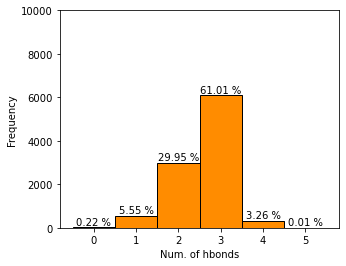

In [26]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
vals = ax.hist(n_hbond_data['Num of hbonds'], bins=np.arange((n_hbond_data['Num of hbonds'].max()) + 2) - 0.5, edgecolor='k', color='#ff8c00')
ax.set_xticks(ticks=np.arange(n_hbond_data['Num of hbonds'].max() + 1))
ax.set_ylim(0, 10000)
ax.set_xlabel('Num. of hbonds')
ax.set_ylabel('Frequency')
#ax.set_title('HBONDS: MeOH - H2O')
rects = ax.patches
labels = [f'{(int(x)/np.sum(vals[0]))*100:.2f} %' for x in vals[0]]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')
#plt.savefig('burnn_hbonds_overviwe.svg', format='svg')
plt.show()

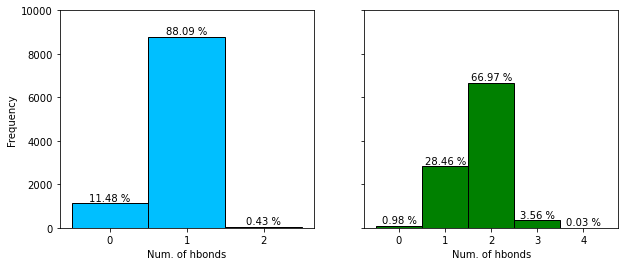

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
vals0 = ax[0].hist(donor_meoh_hbonds_count, bins=np.arange(max(donor_meoh_hbonds_count) + 2)-0.5, edgecolor='k', color='#00bfff')
ax[0].set_xticks(ticks=np.arange(max(donor_meoh_hbonds_count)+1))
ax[0].set_ylim(0, 10000)
#ax[0].set_title('HBONDS: DONOR MeOH')
ax[0].set_xlabel('Num. of hbonds')
ax[0].set_ylabel('Frequency')
vals1 = ax[1].hist(donor_ow_hbonds_count, bins=np.arange((max(donor_ow_hbonds_count)+2))-0.5, edgecolor='k', color='#008000')
values = [vals0, vals1]
ax[1].set_xticks(ticks=np.arange(max(donor_ow_hbonds_count)+1))
ax[1].set_ylim(0, 10000)
#ax[1].set_title('HBONDS: DONOR H2O')
ax[1].set_xlabel('Num. of hbonds')

for i in range(len(ax)):
    rects = ax[i].patches
    labels = [f'{(int(x)/np.sum(values[i][0]))*100:.2f} %' for x in values[i][0]]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax[i].text(rect.get_x() + rect.get_width() / 2, height+10, label,
                ha='center', va='bottom')
#plt.savefig('burnn_hbonds.svg', format='svg')
plt.show()

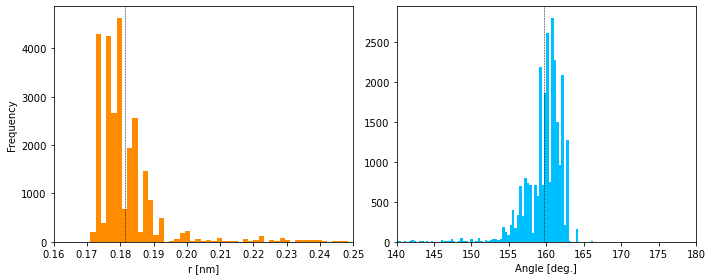

In [28]:
#hbond_geom_check = hbond_data.loc[:,('DIST', 'ANGLE', 'OCCUR')]
#hbond_geom_check.head()
dists = []
angles = []
for dist, angle, occur in zip(hbond_data['DIST'], hbond_data['ANGLE'], hbond_data['OCCUR']):
    _dist = [dist] * int(occur)
    for item in _dist:
        dists.append(item)
    _angle = [angle] * int(occur)
    for item in _angle:
        angles.append(item)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(dists, bins=50, color = '#ff8c00')
ax[1].hist(angles, bins=100, color='#00bfff')
ax[0].axvline(np.mean(dists), color='k', linestyle='--', linewidth=0.5)
ax[1].axvline(np.mean(angles), color='k', linestyle='--', linewidth=0.5)
ax[0].set_xlabel('r [nm]')
ax[1].set_xlabel('Angle [deg.]')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0.16, 0.25)
ax[1].set_xlim(140, 180)
plt.tight_layout()
#plt.savefig('burnn_hbonds_geom.svg', format='svg')
plt.show()

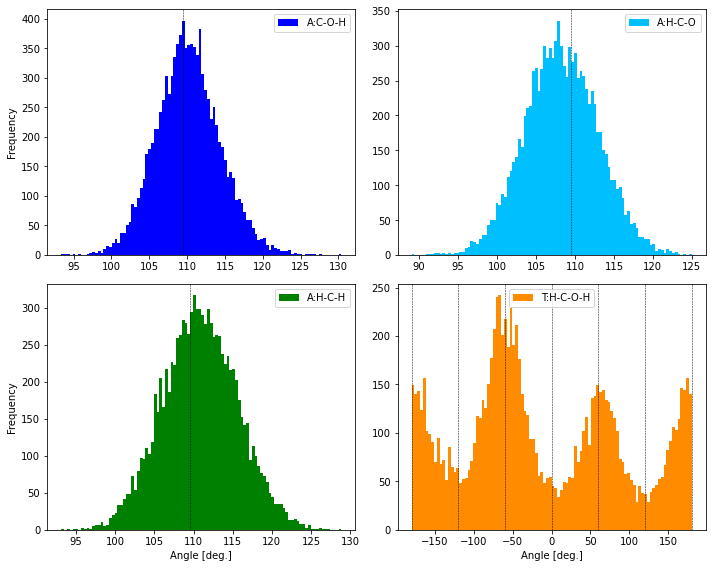

In [29]:
tser_data = tser(tser_raw, ['Time [ps]', 'A:C-O-H', 'A:H-C-O', 'A:H-C-H', 'T:H-C-O-H'])
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

tser_data.plot.hist(y='A:C-O-H', bins=100, ax=ax[0][0], color = '#0000ff')
tser_data.plot.hist(y='A:H-C-O',bins=100, ax=ax[0][1], color='#00bfff')
tser_data.plot.hist(y='A:H-C-H', bins=100, ax=ax[1][0], color='#008000')
tser_data.plot.hist(y='T:H-C-O-H', bins=100, ax=ax[1][1], color='#ff8c00')
ax[0][0].axvline(109.5, color='k', linestyle='--', linewidth=0.5)
ax[0][1].axvline(109.5, color='k', linestyle='--', linewidth=0.5)
ax[0][1].set_ylabel('')
ax[1][1].set_ylabel('')
ax[1][0].set_xlabel('Angle [deg.]')
ax[1][0].axvline(109.5, color='k', linestyle='--', linewidth=0.5)
ax[1][1].set_xlabel('Angle [deg.]')
extremes =[-180, -120, -60,  0, 60, 120, 180]
for _ext in extremes:
    ax[1][1].axvline(_ext, color='k', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig('burnn_angles.svg', format='svg')
plt.show()

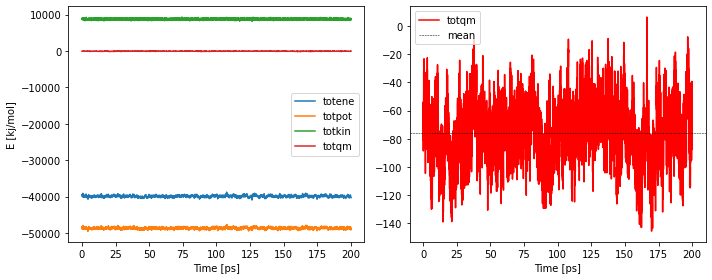

In [30]:
ene_data = energy(energies)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ene_data.plot(y=['totene', 'totpot', 'totkin', 'totqm'], ylabel='E [kj/mol]', ax=ax[0])
ene_data.plot(y='totqm', ax=ax[1], color='red')
ax[1].axhline(ene_data['totqm'].mean(), color='k', linestyle='--', linewidth=0.5, label='mean')
plt.legend()
plt.tight_layout()
#plt.savefig('energy.svg', format='svg')
plt.show()

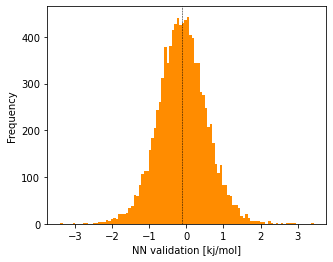

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(ene_data['nnvalid'], bins=100, color='#ff8c00')
ax.axvline(np.mean(ene_data['nnvalid']), color='k', linestyle='--', linewidth=0.5)
ax.set_xlabel('NN validation [kj/mol]')
ax.set_ylabel('Frequency')
plt.savefig('burnn_nnvalid.png', format='png')
plt.show()

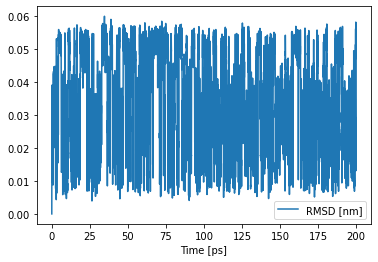

In [32]:
rmsd_data = rmsd(rmsd_raw)
rmsd_data.plot(y='RMSD [nm]')
plt.show()

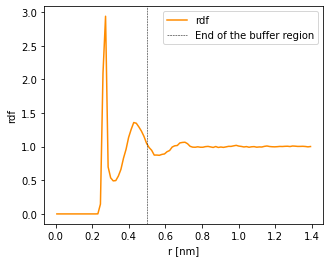

In [33]:
rdf_data = rdf(rdf_raw)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
rdf_data.plot(y='rdf', ax=ax, color='#ff8c00')
#ax.axhline(1, color='k', linestyle='--', linewidth=0.5)
ax.axvline(0.5, color='k', linestyle='--', linewidth=0.5, label='End of the buffer region')
ax.set_ylabel('rdf')
plt.legend()
#plt.savefig('burnn_rdf.svg', format='svg')
plt.show()